In [1]:
# =========================
# 1. IMPORT REQUIRED LIBRARIES
# =========================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Create output directory
output_dir = '/kaggle/working/plots'
os.makedirs(output_dir, exist_ok=True)

/kaggle/input/itmo-flat-price-prediction-2025-2026/Archive2025/solution_example_full.csv
/kaggle/input/itmo-flat-price-prediction-2025-2026/Archive2025/solution_example.csv
/kaggle/input/itmo-flat-price-prediction-2025-2026/Archive2025/test.csv
/kaggle/input/itmo-flat-price-prediction-2025-2026/Archive2025/data.csv
/kaggle/input/itmo-flat-price-prediction-2025-2026/archive/solution_example_full.csv
/kaggle/input/itmo-flat-price-prediction-2025-2026/archive/solution_example.csv
/kaggle/input/itmo-flat-price-prediction-2025-2026/archive/test.csv
/kaggle/input/itmo-flat-price-prediction-2025-2026/archive/data.csv


In [2]:
# =========================
# 2. DATA LOADING
# =========================
train_df = pd.read_csv("/kaggle/input/itmo-flat-price-prediction-2025-2026/Archive2025/data.csv")
test_df  = pd.read_csv("/kaggle/input/itmo-flat-price-prediction-2025-2026/Archive2025/test.csv")

# Remove 'index' column from training set to prevent data leakage
train_df = train_df.drop(columns=['index'], errors='ignore')
# Store test set IDs for final submission file
test_ids = test_df['index']
test_df = test_df.drop(columns=['index'], errors='ignore')

In [3]:
# =========================
# 3. TARGET VARIABLE TRANSFORMATION
# =========================
# Apply log transformation to reduce right-skewness (skewness = 1.01)
y = np.log1p(train_df['price'])
# Remove price from features to prevent target leakage
train_df = train_df.drop(columns=['price'])

In [4]:
# =========================
# 4. COMBINE DATASETS FOR CONSISTENT FEATURE ENGINEERING
# =========================
# Mark training vs test samples to split them later
train_df['is_train'] = 1
test_df['is_train']  = 0
# Concatenate to ensure identical transformations applied to both sets
full_df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)

In [5]:
# =========================
# 5. FEATURE ENGINEERING
# =========================

# --- Temporal Features ---
# Calculate building age (assuming current year is 2026)
full_df['building_age'] = 2026 - full_df['year']
full_df['is_modern'] = (full_df['year'] > 2015).astype(int)
full_df['is_historic'] = (full_df['year'] < 1960).astype(int)
# --- Area-Based Features ---
full_df['room_size'] = full_df['total_area'] / (full_df['rooms_count'] + 1)
full_df['area_per_bath'] = full_df['total_area'] / (full_df['bath_count'] + 1)
# --- Spatial Efficiency Ratios ---
full_df['kitchen_ratio'] = full_df['kitchen_area'] / (full_df['total_area'] + 1)
full_df['service_area_total'] = full_df['kitchen_area'] + full_df['bath_area'] + full_df['other_area']
full_df['living_to_service_ratio'] = full_df['total_area'] / (full_df['service_area_total'] + 1)
# --- Floor Position Features ---
full_df['floor_ratio'] = full_df['floor'] / (full_df['floor_max'] + 1)
full_df['is_top_floor'] = (full_df['floor'] == full_df['floor_max']).astype(int)
full_df['is_first_floor'] = (full_df['floor'] == 1).astype(int)
full_df['is_high_rise'] = (full_df['floor_max'] > 12).astype(int)

In [6]:
# =========================
# 6. Categorical Encoding
# =========================

# Convert categorical columns to 'category' dtype
cat_cols = [
    'gas', 
    'hot_water', 
    'central_heating', 
    'extra_area_type_name', 
    'district_name'
]
for col in cat_cols:
    full_df[col] = full_df[col].astype('category')

In [7]:
# =========================
# 7. DATA BRANCHING FOR DIFFENT MODELS
# =========================

# 1. Keep RAW categorical data for models with native support
full_df_raw = full_df.copy()

X = full_df_raw[full_df_raw['is_train'] == 1].drop(columns=['is_train'])
X_test = full_df_raw[full_df_raw['is_train'] == 0].drop(columns=['is_train'])

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# 2. Encoding for Random Forest
full_df_rf = full_df.copy()

ordinal_encoder = OrdinalEncoder(
    handle_unknown="use_encoded_value",
    unknown_value=-1
)

full_df_rf[cat_cols] = ordinal_encoder.fit_transform(
    full_df_rf[cat_cols]
)

X_rf = full_df_rf[full_df_rf['is_train'] == 1].drop(columns=['is_train'])
X_rf_test = full_df_rf[full_df_rf['is_train'] == 0].drop(columns=['is_train'])

X_rf_train, X_rf_val, y_rf_train, y_rf_val = train_test_split(
    X_rf, y, test_size=0.2, random_state=42
)



----------------------------------------------------------------------

--- Validation Results for Random Forest (Baseline) ---
RMSLE: 0.0185
RMSE: 306,428.40
MAE:  230,066.39
R²:   0.9973
MAPE: 1.44%


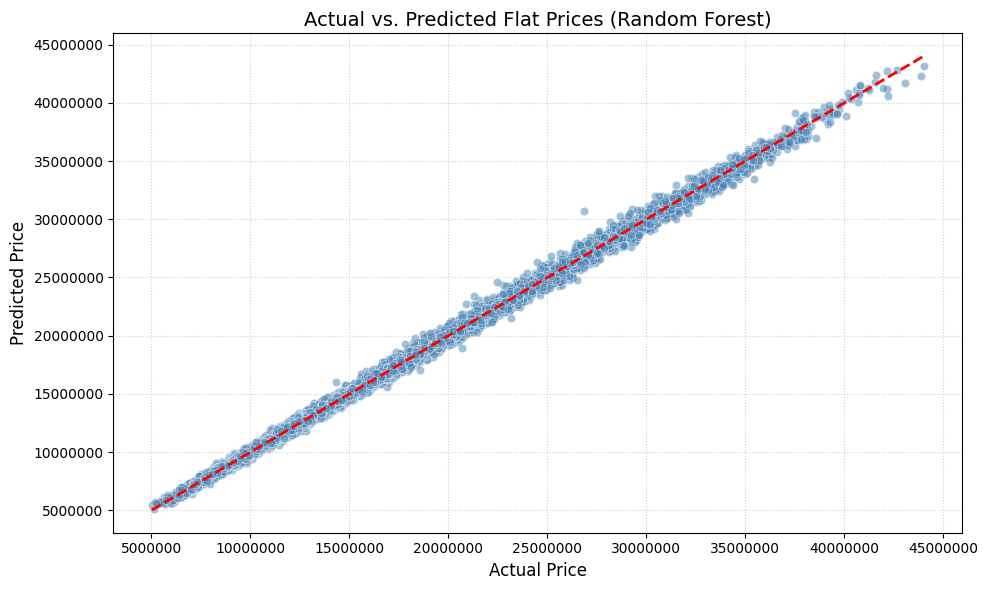

In [8]:
# =========================
# 8. MODELS TRAINING
# =========================

# MODEL 0 - RANDOM FOREST (BASELINE)

rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=25,
    max_features=None,
    min_samples_leaf=1,
    n_jobs=-1,
    random_state=42
)

# ----------------------------------------------------
# TRAIN (RF-SPECIFIC DATA)
# ----------------------------------------------------
rf_model.fit(X_rf_train, y_rf_train)

# ----------------------------------------------------
# VALIDATION METRICS
# ----------------------------------------------------
val_preds_log = rf_model.predict(X_rf_val)

# 1. Calculate RMSLE
rf_rmsle = np.sqrt(mean_squared_error(y_rf_val, val_preds_log))

# 2. Convert back to actual currency for other metrics
y_val_actual = np.expm1(y_rf_val)
y_val_pred   = np.expm1(val_preds_log)

# 3. Calculate standard metrics
rf_rmse = np.sqrt(mean_squared_error(y_val_actual, y_val_pred))
rf_mae  = mean_absolute_error(y_val_actual, y_val_pred)
rf_r2   = r2_score(y_val_actual, y_val_pred)
rf_mape = np.mean(np.abs((y_val_actual - y_val_pred) / y_val_actual)) * 100

print("\n" + "-" * 70)
print("\n--- Validation Results for Random Forest (Baseline) ---")
print(f"RMSLE: {rf_rmsle:.4f}")
print(f"RMSE: {rf_rmse:,.2f}")
print(f"MAE:  {rf_mae:,.2f}")
print(f"R²:   {rf_r2:.4f}")
print(f"MAPE: {rf_mape:.2f}%")

# ----------------------------------------------------
# VISUALIZATION
# ----------------------------------------------------
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=y_val_actual,
    y=y_val_pred,
    alpha=0.5,
    color='steelblue'
)

# 45-degree reference line
max_val = max(y_val_actual.max(), y_val_pred.max())
min_val = min(y_val_actual.min(), y_val_pred.min())
plt.plot(
    [min_val, max_val],
    [min_val, max_val],
    color='red',
    lw=2,
    linestyle='--'
)

plt.title(
    f'Actual vs. Predicted Flat Prices (Random Forest)',
    fontsize=14
)
plt.xlabel('Actual Price', fontsize=12)
plt.ylabel('Predicted Price', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.6)
plt.ticklabel_format(style='plain', axis='both')
plt.tight_layout()

plt.savefig(
    f'{output_dir}/00_Actual_vs_Predicted_Flat_Prices_(Random_Forest).png',
    dpi=300,
    bbox_inches="tight"
)

plt.show()
plt.close()

[0]	validation_0-rmse:0.33753
[200]	validation_0-rmse:0.01281
[400]	validation_0-rmse:0.01163
[600]	validation_0-rmse:0.01153
[800]	validation_0-rmse:0.01150
[1000]	validation_0-rmse:0.01149
[1108]	validation_0-rmse:0.01149

----------------------------------------------------------------------

--- Validation Results for XGBoost ---
RMSLE: 0.0115
RMSE: 167,582.97
MAE:  137,831.87
R²:   0.9992
MAPE: 0.92%


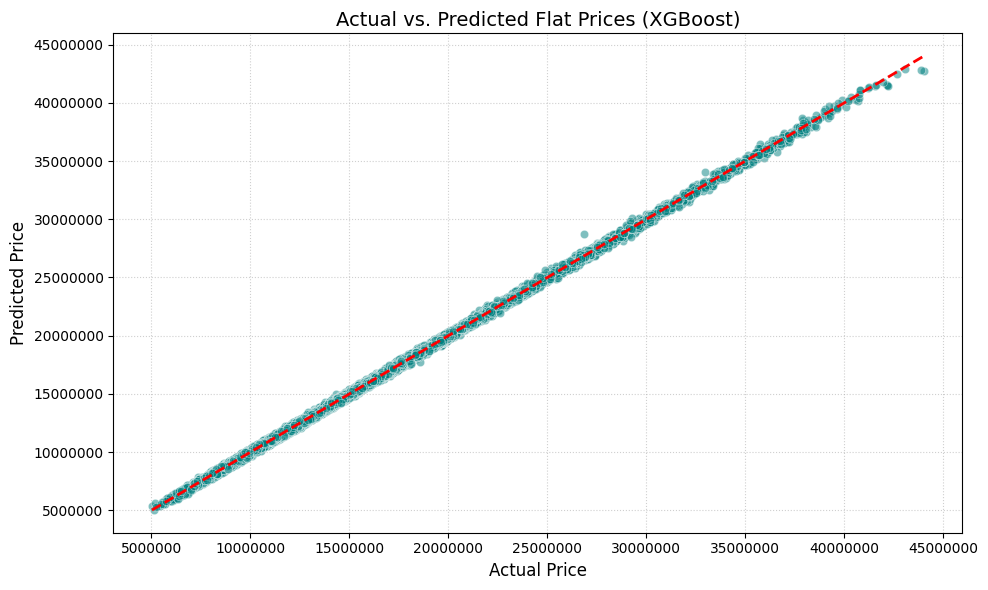

In [9]:
# MODEL 1 - XGBOOST

# ----------------------------------------------------
# HYPERPARAMETERS
# ----------------------------------------------------
xgb_model = XGBRegressor(
    n_estimators=3000,
    learning_rate=0.03,
    max_depth=8,
    objective='reg:squarederror',
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method='hist',
    enable_categorical=True,
    early_stopping_rounds=100
)

# ----------------------------------------------------
# TRAIN
# ----------------------------------------------------
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=200
)

# ----------------------------------------------------
# VALIDATION METRICS
# ----------------------------------------------------

val_preds_log = xgb_model.predict(X_val)

# 1. Calculate RMSLE
xgb_rmsle = np.sqrt(mean_squared_error(y_val, val_preds_log))

# 2. Convert back to actual currency for other metrics
y_val_actual = np.expm1(y_val)
y_val_pred   = np.expm1(val_preds_log)

# 3. Calculate standard metrics
xgb_rmse = np.sqrt(mean_squared_error(y_val_actual, y_val_pred))
xgb_mae  = mean_absolute_error(y_val_actual, y_val_pred)
xgb_r2   = r2_score(y_val_actual, y_val_pred)
xgb_mape = np.mean(np.abs((y_val_actual - y_val_pred) / y_val_actual)) * 100

print("\n" + "-"*70)

print(f"\n--- Validation Results for XGBoost ---")
print(f"RMSLE: {xgb_rmsle:,.4f}")
print(f"RMSE: {xgb_rmse:,.2f}")
print(f"MAE:  {xgb_mae:,.2f}")
print(f"R²:   {xgb_r2:.4f}")
print(f"MAPE: {xgb_mape:.2f}%")

# ----------------------------------------------------
# VISUALIZATION
# ----------------------------------------------------

# Create the plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_val_actual, y=y_val_pred, alpha=0.5, color='teal')

# Add a 45-degree line (Perfect Prediction Line)
max_val = max(y_val_actual.max(), y_val_pred.max())
min_val = min(y_val_actual.min(), y_val_pred.min())
plt.plot([min_val, max_val], [min_val, max_val], color='red', lw=2, linestyle='--')

# Formatting
plt.title(f'Actual vs. Predicted Flat Prices (XGBoost)', fontsize=14)
plt.xlabel('Actual Price', fontsize=12)
plt.ylabel('Predicted Price', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.6)
plt.ticklabel_format(style='plain', axis='both')
plt.tight_layout()
plt.savefig(f'{output_dir}/01_Actual_vs_Predicted_Flat_Prices_(XGBoost).png', dpi=300, bbox_inches="tight")
plt.show()
plt.close()

Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 0.0131699
[400]	valid_0's rmse: 0.0117882
[600]	valid_0's rmse: 0.0116528
[800]	valid_0's rmse: 0.0115954
[1000]	valid_0's rmse: 0.0115643
[1200]	valid_0's rmse: 0.0115511
Early stopping, best iteration is:
[1233]	valid_0's rmse: 0.0115485

----------------------------------------------------------------------

--- Validation Results for LightGBM ---
RMSLE: 0.0115
RMSE:  169,282.86
MAE:   139,402.89
R²:    0.9992
MAPE:  0.93%


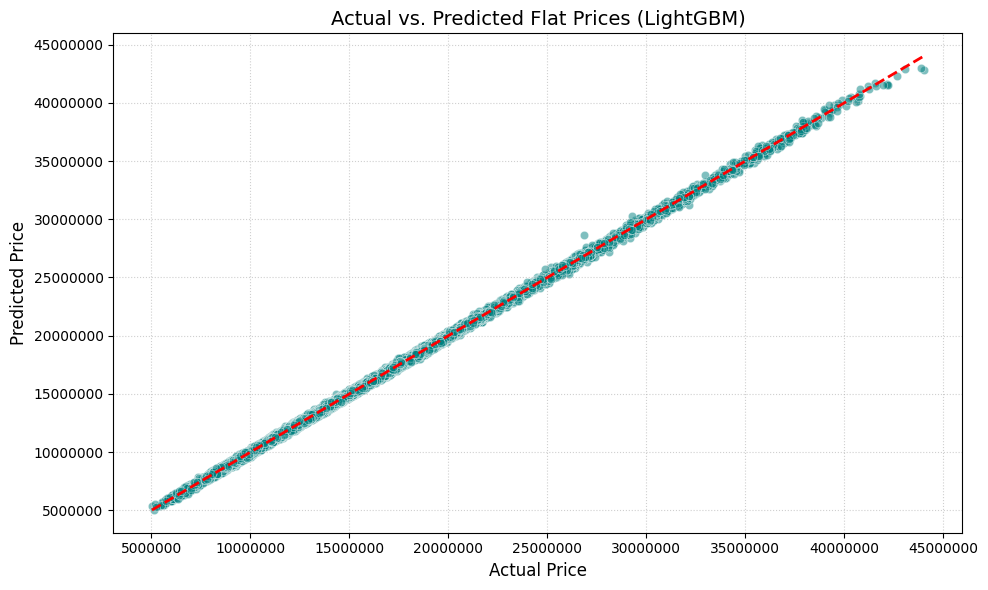

In [10]:
# MODEL 2 - LightGBM

# ----------------------------------------------------
# ENSURE CATEGORICAL DTYPES
# ----------------------------------------------------
for col in cat_cols:
    X_train[col] = X_train[col].astype('category')
    X_val[col] = X_val[col].astype('category')
    
# ----------------------------------------------------
# HYPERPARAMETERS
# ----------------------------------------------------
lgbm_model = lgb.LGBMRegressor(
    n_estimators=3000,
    learning_rate=0.03,
    max_depth=8,
    num_leaves=200,
    objective='regression',
    metric='rmse',
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_samples=20,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    verbose=-1
)

# ----------------------------------------------------
# TRAIN
# ----------------------------------------------------
lgbm_model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    categorical_feature=cat_cols,
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(period=200)
    ]
)

# ----------------------------------------------------
# VALIDATION METRICS
# ----------------------------------------------------

val_preds_log = lgbm_model.predict(X_val)

# 1. Calculate RMSLE
lgbm_rmsle = np.sqrt(mean_squared_error(y_val, val_preds_log))

# 2. Convert back to actual currency for other metrics
y_val_actual = np.expm1(y_val)
y_val_pred   = np.expm1(val_preds_log)

# 3. Calculate standard metrics
lgbm_rmse = np.sqrt(mean_squared_error(y_val_actual, y_val_pred))
lgbm_mae  = mean_absolute_error(y_val_actual, y_val_pred)
lgbm_r2   = r2_score(y_val_actual, y_val_pred)
lgbm_mape = np.mean(np.abs((y_val_actual - y_val_pred) / y_val_actual)) * 100

print("\n" + "-"*70)

print(f"\n--- Validation Results for LightGBM ---")
print(f"RMSLE: {lgbm_rmsle:,.4f}")
print(f"RMSE:  {lgbm_rmse:,.2f}")
print(f"MAE:   {lgbm_mae:,.2f}")
print(f"R²:    {lgbm_r2:.4f}")
print(f"MAPE:  { lgbm_mape:.2f}%")

# ----------------------------------------------------
# VISUALIZATION
# ----------------------------------------------------

# Create the plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_val_actual, y=y_val_pred, alpha=0.5, color='teal')

# Add a 45-degree line (Perfect Prediction Line)
max_val = max(y_val_actual.max(), y_val_pred.max())
min_val = min(y_val_actual.min(), y_val_pred.min())
plt.plot([min_val, max_val], [min_val, max_val], color='red', lw=2, linestyle='--')

# Formatting
plt.title(f'Actual vs. Predicted Flat Prices (LightGBM)', fontsize=14)
plt.xlabel('Actual Price', fontsize=12)
plt.ylabel('Predicted Price', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.6)
plt.ticklabel_format(style='plain', axis='both')
plt.tight_layout()
plt.savefig(f'{output_dir}/02_Actual_vs_Predicted_Flat_Prices_(LightGBM).png', dpi=300, bbox_inches="tight")
plt.show()
plt.close()

0:	learn: 0.3405178	test: 0.3379542	best: 0.3379542 (0)	total: 110ms	remaining: 5m 29s
200:	learn: 0.0175449	test: 0.0147496	best: 0.0147496 (200)	total: 7.99s	remaining: 1m 51s
400:	learn: 0.0144202	test: 0.0120600	best: 0.0120600 (400)	total: 15.2s	remaining: 1m 38s
600:	learn: 0.0131686	test: 0.0115352	best: 0.0115352 (600)	total: 22.1s	remaining: 1m 28s
800:	learn: 0.0124972	test: 0.0113017	best: 0.0113017 (800)	total: 29s	remaining: 1m 19s
1000:	learn: 0.0120663	test: 0.0111615	best: 0.0111615 (1000)	total: 36.1s	remaining: 1m 12s
1200:	learn: 0.0117778	test: 0.0110645	best: 0.0110645 (1200)	total: 43.5s	remaining: 1m 5s
1400:	learn: 0.0114976	test: 0.0109915	best: 0.0109915 (1400)	total: 50.7s	remaining: 57.9s
1600:	learn: 0.0112712	test: 0.0109414	best: 0.0109414 (1600)	total: 58.5s	remaining: 51.1s
1800:	learn: 0.0111282	test: 0.0109108	best: 0.0109106 (1797)	total: 1m 6s	remaining: 44s
2000:	learn: 0.0109960	test: 0.0108873	best: 0.0108873 (2000)	total: 1m 14s	remaining: 37.4s

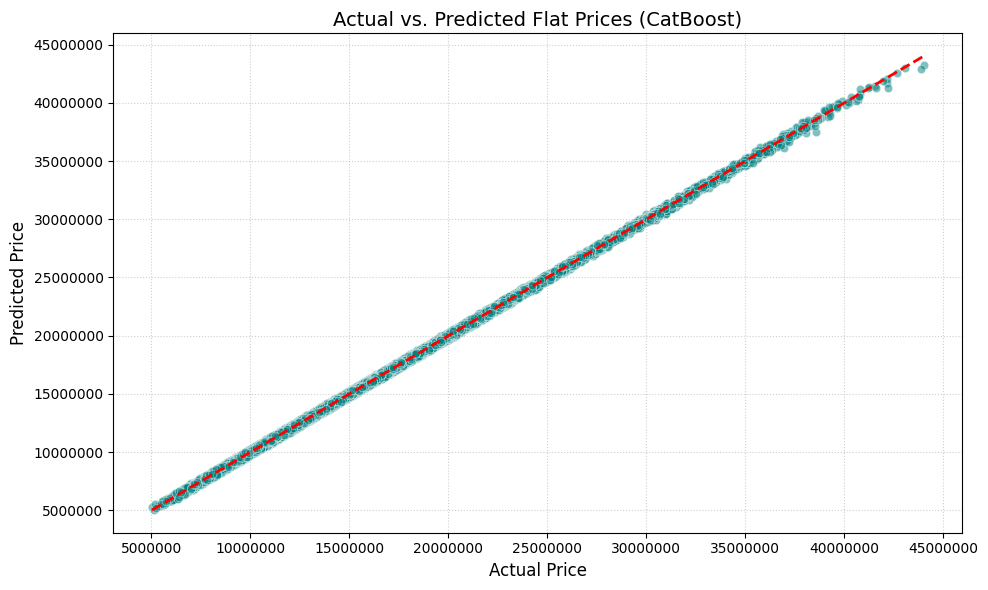

In [11]:
# MODEL 3 - CATBOOST

# ----------------------------------------------------
# HYPERPARAMETERS
# ----------------------------------------------------
cb_model = CatBoostRegressor(
    iterations=3000,
    learning_rate=0.03,
    depth=8,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=42,
    early_stopping_rounds=100,
    verbose=200
)

# ----------------------------------------------------
# TRAIN
# ----------------------------------------------------
cb_model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    cat_features=cat_cols
)

# ----------------------------------------------------
# VALIDATION METRICS
# ----------------------------------------------------

val_preds_log = cb_model.predict(X_val)

# 1. Calculate RMSLE
cb_rmsle = np.sqrt(mean_squared_error(y_val, val_preds_log))

# 2. Convert back to actual currency for other metrics
y_val_actual = np.expm1(y_val)
y_val_pred   = np.expm1(val_preds_log)

# 3. Calculate standard metrics
cb_rmse = np.sqrt(mean_squared_error(y_val_actual, y_val_pred))
cb_mae  = mean_absolute_error(y_val_actual, y_val_pred)
cb_r2   = r2_score(y_val_actual, y_val_pred)
cb_mape = np.mean(np.abs((y_val_actual - y_val_pred) / y_val_actual)) * 100

print("\n" + "-"*70)

print(f"\n--- Validation Results for CatBoost ---")
print(f"RMSLE: {cb_rmsle:,.4f}")
print(f"RMSE:  {cb_rmse:,.2f}")
print(f"MAE:   {cb_mae:,.2f}")
print(f"R²:    {cb_r2:.4f}")
print(f"MAPE:  {cb_mape:.2f}%")

# ----------------------------------------------------
# VISUALIZATION
# ----------------------------------------------------

# Create the plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_val_actual, y=y_val_pred, alpha=0.5, color='teal')

# Add a 45-degree line (Perfect Prediction Line)
max_val = max(y_val_actual.max(), y_val_pred.max())
min_val = min(y_val_actual.min(), y_val_pred.min())
plt.plot([min_val, max_val], [min_val, max_val], color='red', lw=2, linestyle='--')

# Formatting
plt.title(f'Actual vs. Predicted Flat Prices (CatBoost)', fontsize=14)
plt.xlabel('Actual Price', fontsize=12)
plt.ylabel('Predicted Price', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.6)
plt.ticklabel_format(style='plain', axis='both')
plt.tight_layout()
plt.savefig(f'{output_dir}/03_Actual_vs_Predicted_Flat_Prices_(CatBoost).png', dpi=300, bbox_inches="tight")
plt.show()
plt.close()


----------------------------------------------------------------------

--- Validation Results for Hybrid Ensemble ---
RMSLE: 0.0115
RMSE:  167,582.97
MAE:   137,831.87
R²:    0.9992
MAPE:  0.92%


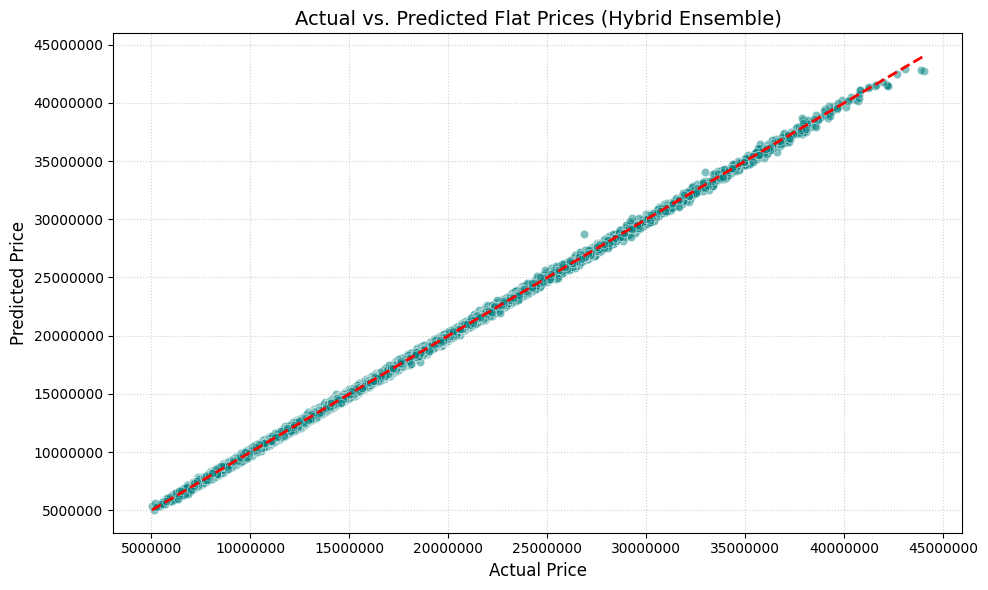

In [12]:
# MODEL 4: HYBRID ENSEMBLE (WEIGHTED AVERAGING)

# Ensemble combines predictions from XGBoost, LightGBM, and CatBoost
# to leverage each model's strengths and reduce individual model biases

# ----------------------------------------------------
# STEP 1: COLLECT PREDICTIONS FROM BASE MODELS
# ----------------------------------------------------
# Extract predictions from all three trained models (in log-transformed space)
xgb_log_preds  = xgb_model.predict(X_val)
lgbm_log_preds = lgbm_model.predict(X_val)
cb_log_preds   = cb_model.predict(X_val)

# ----------------------------------------------------
# STEP 2: DEFINE ENSEMBLE WEIGHTS
# ----------------------------------------------------
# Weight allocation based on individual model validation performance
w_xgb  = 0.20  # 20% contribution from XGBoost
w_lgbm = 0.20  # 20% contribution from LightGBM
w_cb   = 0.60  # 60% contribution from CatBoost (dominant model)

# ----------------------------------------------------
# STEP 3: COMPUTE WEIGHTED ENSEMBLE PREDICTION
# ----------------------------------------------------
hybrid_log_preds = (w_xgb * xgb_log_preds) + (w_lgbm * lgbm_log_preds) + (w_cb * cb_log_preds)

# ----------------------------------------------------
# STEP 4: TRANSFORM BACK TO ORIGINAL PRICE SCALE
# ----------------------------------------------------
# Convert both ensemble predictions and actual values from log-space to price scale
y_val_actual = np.expm1(y_val)           # Actual prices
y_val_pred   = np.expm1(hybrid_log_preds) # Ensemble predicted prices

# ----------------------------------------------------
# VALIDATION METRICS
# ----------------------------------------------------

val_preds_log = xgb_model.predict(X_val)

# 1. Calculate RMSLE
h_rmsle = np.sqrt(mean_squared_error(y_val, val_preds_log))

# 2. Convert back to actual currency for other metrics
y_val_actual = np.expm1(y_val)
y_val_pred   = np.expm1(val_preds_log)

# 3. Calculate standard metrics
h_rmse = np.sqrt(mean_squared_error(y_val_actual, y_val_pred))
h_mae  = mean_absolute_error(y_val_actual, y_val_pred)
h_r2   = r2_score(y_val_actual, y_val_pred)
h_mape = np.mean(np.abs((y_val_actual - y_val_pred) / y_val_actual)) * 100

print("\n" + "-"*70)

print(f"\n--- Validation Results for Hybrid Ensemble ---")
print(f"RMSLE: {h_rmsle:,.4f}")
print(f"RMSE:  {h_rmse:,.2f}")
print(f"MAE:   {h_mae:,.2f}")
print(f"R²:    {h_r2:.4f}")
print(f"MAPE:  {h_mape:.2f}%")

# ----------------------------------------------------
# VISUALIZATION
# ----------------------------------------------------
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_val_actual, y=y_val_pred, alpha=0.5, color='teal')

# Add perfect prediction reference line (45-degree diagonal)
max_val = max(y_val_actual.max(), y_val_pred.max())
min_val = min(y_val_actual.min(), y_val_pred.min())
plt.plot([min_val, max_val], [min_val, max_val], color='red', lw=2, linestyle='--',
         label='Perfect Prediction')

# Formatting and labels
plt.title(f'Actual vs. Predicted Flat Prices (Hybrid Ensemble)', fontsize=14)
plt.xlabel('Actual Price', fontsize=12)
plt.ylabel('Predicted Price', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.6)
plt.ticklabel_format(style='plain', axis='both')
plt.tight_layout()
plt.savefig(f'{output_dir}/04_Actual_vs_Predicted_Flat_Prices_Hybrid.png', 
            dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [13]:
# ==========================================
# 8. EVALUATION SUMMARY
# ==========================================
def print_evaluation_summary(
    rf_rmse, rf_rmsle, rf_mae, rf_r2, rf_mape,
    xgb_rmse, xgb_rmsle, xgb_mae, xgb_r2, xgb_mape,
    lgbm_rmse, lgbm_rmsle, lgbm_mae, lgbm_r2, lgbm_mape,
    cb_rmse, cb_rmsle, cb_mae, cb_r2, cb_mape,
    h_rmse, h_rmsle, h_mae, h_r2, h_mape
):
    """
    Evaluation summary with:
    - RMSE (competition metric)
    - RMSLE (log-target-consistent metric)
    - Random Forest as baseline
    """

    print("\n" + "=" * 90)
    print("MODEL EVALUATION SUMMARY - VALIDATION SET")
    print("Baseline Model: Random Forest")
    print("=" * 90)

    # --------------------------------------------------
    # Results table
    # --------------------------------------------------
    results = pd.DataFrame({
        'Model': [
            'Random Forest (Baseline)',
            'XGBoost',
            'LightGBM',
            'CatBoost',
            'Hybrid Ensemble'
        ],
        'RMSE':  [rf_rmse,  xgb_rmse,  lgbm_rmse,  cb_rmse,  h_rmse],
        'RMSLE': [rf_rmsle, xgb_rmsle, lgbm_rmsle, cb_rmsle, h_rmsle],
        'MAE':   [rf_mae,   xgb_mae,   lgbm_mae,   cb_mae,   h_mae],
        'R²':    [rf_r2,    xgb_r2,    lgbm_r2,    cb_r2,    h_r2],
        'MAPE (%)': [rf_mape, xgb_mape, lgbm_mape, cb_mape, h_mape]
    })

    print("\nFull Metrics Comparison:")
    print(results.to_string(index=False))

    print("\n" + "-" * 90)

    # --------------------------------------------------
    # Improvement vs baseline
    # --------------------------------------------------
    baseline = results.iloc[0]

    improvement = results.copy()
    improvement['Δ RMSE vs RF (%)'] = (baseline['RMSE'] - improvement['RMSE']) / baseline['RMSE'] * 100
    improvement['Δ RMSLE vs RF (%)'] = (baseline['RMSLE'] - improvement['RMSLE']) / baseline['RMSLE'] * 100
    improvement['Δ R² vs RF'] = improvement['R²'] - baseline['R²']

    print("\nImprovement Over Baseline (Random Forest):")
    print(
        improvement[
            ['Model', 'Δ RMSE vs RF (%)', 'Δ RMSLE vs RF (%)', 'Δ R² vs RF']
        ].round(3).to_string(index=False)
    )

    print("\n" + "-" * 90)

    # --------------------------------------------------
    # Best models per metric
    # --------------------------------------------------
    print("\nBest Performance by Metric:")
    print(f"   Lowest RMSE:   {results.loc[results['RMSE'].idxmin(), 'Model']}")
    print(f"   Lowest RMSLE:  {results.loc[results['RMSLE'].idxmin(), 'Model']}")
    print(f"   Lowest MAE:    {results.loc[results['MAE'].idxmin(), 'Model']}")
    print(f"   Highest R²:    {results.loc[results['R²'].idxmax(), 'Model']}")

    print("\n" + "-" * 90)

    # --------------------------------------------------
    # Overall ranking (RMSLE-weighted)
    # --------------------------------------------------
    results['RMSE_rank']  = results['RMSE'].rank()
    results['RMSLE_rank'] = results['RMSLE'].rank()
    results['MAE_rank']   = results['MAE'].rank()
    results['R2_rank']    = results['R²'].rank(ascending=False)

    results['Avg_Rank'] = results[
        ['RMSE_rank', 'RMSLE_rank', 'MAE_rank', 'R2_rank']
    ].mean(axis=1)

    results = results.sort_values('Avg_Rank')
    best_overall = results.iloc[0]['Model']

    print("\nOverall Ranking (lower = better):")
    for _, row in results.iterrows():
        print(f"   {row['Model']:<22} Avg Rank = {row['Avg_Rank']:.2f}")

    print("\n" + "=" * 90)
    print(f"Recommendation: Use **{best_overall}** for final predictions")
    print("=" * 90 + "\n")

    return results
    
# Usage:
summary_df = print_evaluation_summary(
    rf_rmse, rf_rmsle, rf_mae, rf_r2, rf_mape,
    xgb_rmse, xgb_rmsle, xgb_mae, xgb_r2, xgb_mape,
    lgbm_rmse, lgbm_rmsle, lgbm_mae, lgbm_r2, lgbm_mape,
    cb_rmse, cb_rmsle, cb_mae, cb_r2, cb_mape,
    h_rmse, h_rmsle, h_mae, h_r2, h_mape
)



MODEL EVALUATION SUMMARY - VALIDATION SET
Baseline Model: Random Forest

Full Metrics Comparison:
                   Model          RMSE    RMSLE           MAE       R²  MAPE (%)
Random Forest (Baseline) 306428.400732 0.018512 230066.385239 0.997342  1.444935
                 XGBoost 167582.966531 0.011488 137831.865900 0.999205  0.919651
                LightGBM 169282.860595 0.011548 139402.887846 0.999189  0.927560
                CatBoost 153568.469872 0.010830 129753.093914 0.999332  0.875752
         Hybrid Ensemble 167582.966531 0.011488 137831.865900 0.999205  0.919651

------------------------------------------------------------------------------------------

Improvement Over Baseline (Random Forest):
                   Model  Δ RMSE vs RF (%)  Δ RMSLE vs RF (%)  Δ R² vs RF
Random Forest (Baseline)             0.000              0.000       0.000
                 XGBoost            45.311             37.942       0.002
                LightGBM            44.756             37

In [14]:
# ====================================================
# FINAL MODEL: CATBOOST (BEST VALIDATED MODEL)
# ====================================================
# CatBoost performed best during validation
# Now retrained on the FULL dataset (no validation, no early stopping)

from catboost import CatBoostRegressor

# ----------------------------------------------------
# FINAL MODEL (same hyperparameters as validation)
# ----------------------------------------------------
cb_final = CatBoostRegressor(
    iterations=3000,
    learning_rate=0.03,
    depth=8,
    loss_function='RMSE',
    random_seed=42,
    verbose=200
)

# ====================================================
# TRAIN ON FULL TRAINING DATA
# ====================================================
print("Training final CatBoost model on full dataset...")
cb_final.fit(
    X, y,
    cat_features=cat_cols
)
print("✅ Training complete!")

# ====================================================
# GENERATE TEST SET PREDICTIONS
# ====================================================
test_preds_log = cb_final.predict(X_test)

# Reverse log1p transformation
final_prices = np.expm1(test_preds_log)

# ====================================================
# CREATE SUBMISSION FILE
# ====================================================
submission = pd.DataFrame({
    'index': test_ids,
    'price': final_prices
})

submission.to_csv("/kaggle/working/submission.csv", index=False)

print("\n✅ Submission saved to /kaggle/working/submission.csv")
print(f"Predicted {len(final_prices):,} test samples")
print(f"Price range: ₽{final_prices.min():,.0f} - ₽{final_prices.max():,.0f}")


Training final CatBoost model on full dataset...
0:	learn: 0.3400550	total: 48.6ms	remaining: 2m 25s
200:	learn: 0.0178536	total: 8.62s	remaining: 2m
400:	learn: 0.0135671	total: 16.8s	remaining: 1m 48s
600:	learn: 0.0126821	total: 24.5s	remaining: 1m 37s
800:	learn: 0.0122306	total: 32.3s	remaining: 1m 28s
1000:	learn: 0.0119286	total: 40.1s	remaining: 1m 20s
1200:	learn: 0.0117173	total: 48.3s	remaining: 1m 12s
1400:	learn: 0.0115500	total: 56.8s	remaining: 1m 4s
1600:	learn: 0.0113881	total: 1m 4s	remaining: 56.7s
1800:	learn: 0.0112491	total: 1m 13s	remaining: 48.7s
2000:	learn: 0.0111190	total: 1m 21s	remaining: 40.8s
2200:	learn: 0.0110028	total: 1m 30s	remaining: 32.7s
2400:	learn: 0.0108946	total: 1m 40s	remaining: 25.1s
2600:	learn: 0.0107927	total: 1m 50s	remaining: 16.9s
2800:	learn: 0.0106953	total: 2m	remaining: 8.58s
2999:	learn: 0.0105765	total: 2m 13s	remaining: 0us
✅ Training complete!

✅ Submission saved to /kaggle/working/submission.csv
Predicted 100,000 test samples


RESIDUAL ANALYSIS
CatBoost model

Residuals vs predicted values


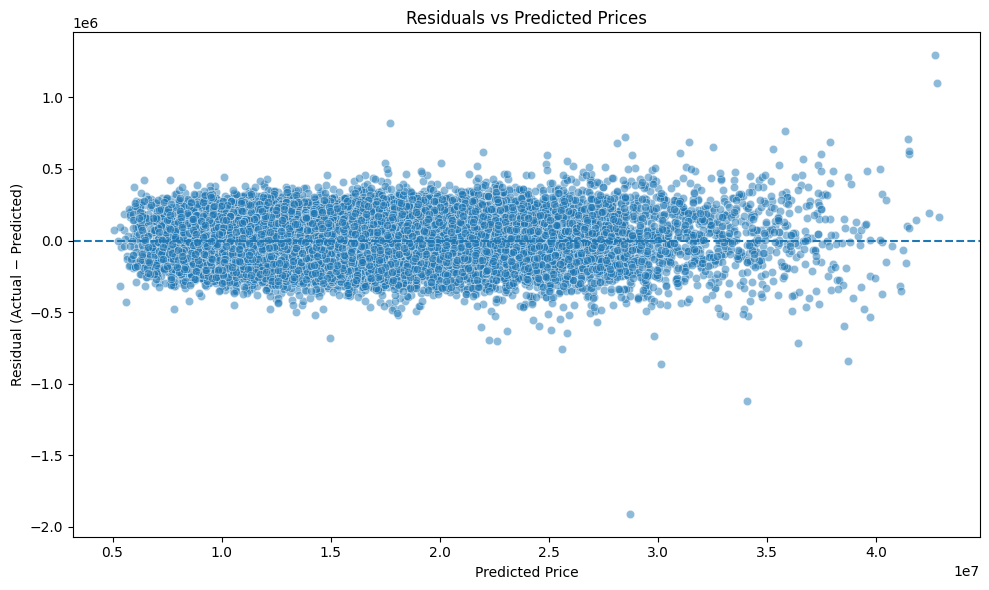


Residuals distribution with histogram and KDE


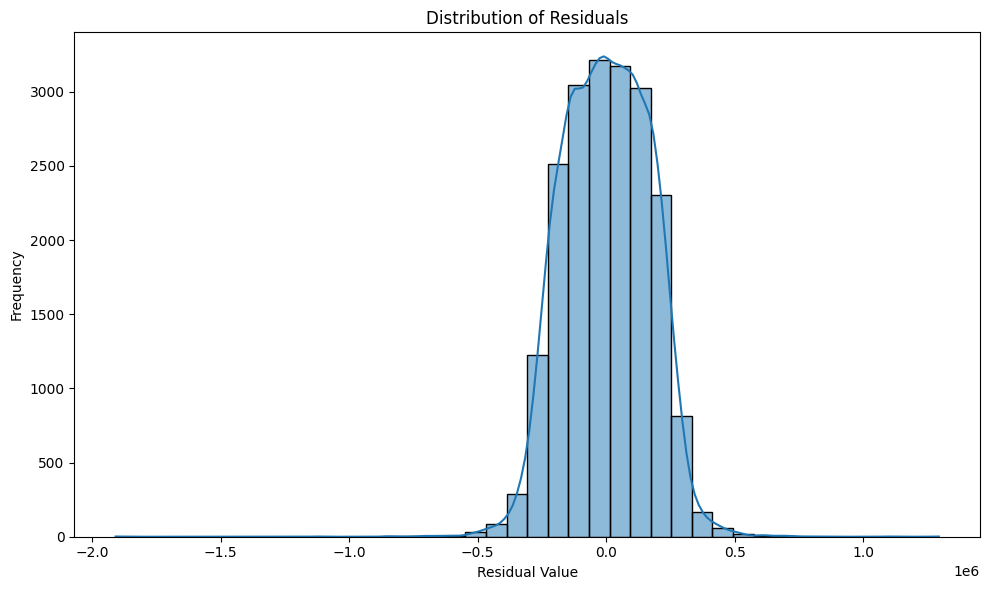


Residuals vs actual values


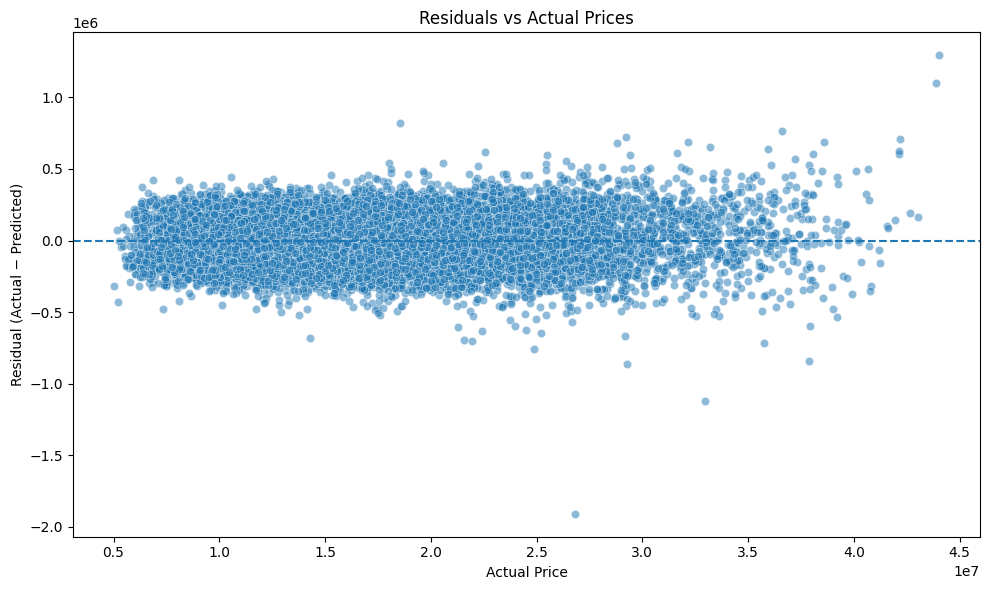


Q-Q plot


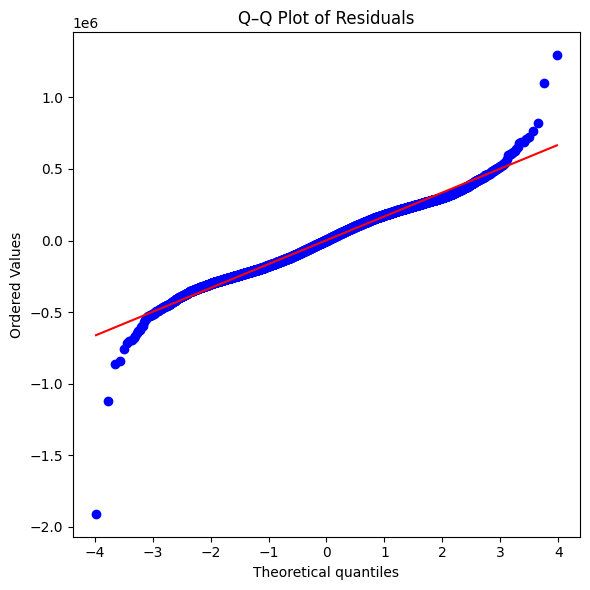


Summary Statistics
Mean Residual: 1940.77
Median Residual: 2430.50
Std Deviation: 167571.73
Min Residual: -1908636.00
Max Residual: 1294127.00


In [15]:
# ==========================================
# RESIDUAL ANALYSIS FOR CATBOOST MODEL
# ==========================================
print("\n" + "=" * 90)
print("RESIDUAL ANALYSIS")
print("CatBoost model")
print("=" * 90)


# Residuals
residuals = y_val_actual - y_val_pred


# 1. Residuals vs predicted values
print("\nResiduals vs predicted values")

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_val_pred, y=residuals, alpha=0.5)

# Zero-error reference line
plt.axhline(0, linestyle='--')

plt.xlabel("Predicted Price")
plt.ylabel("Residual (Actual − Predicted)")
plt.title("Residuals vs Predicted Prices")
plt.tight_layout()
plt.savefig(f'{output_dir}/05_residuals_vs_predicted_prices.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# 2. Residuals distribution with histogram and KDE
print("\nResiduals distribution with histogram and KDE")
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=40, kde=True)

plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.tight_layout()
plt.savefig(f'{output_dir}/06_residuals_distribution.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# 3. Residuals vs actual values
print("\nResiduals vs actual values")
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_val_actual, y=residuals, alpha=0.5)
plt.axhline(0, linestyle='--')

plt.xlabel("Actual Price")
plt.ylabel("Residual (Actual − Predicted)")
plt.title("Residuals vs Actual Prices")
plt.tight_layout()
plt.savefig(f'{output_dir}/07_residuals_vs_actual_prices.png', 
            dpi=300, bbox_inches='tight')
plt.show()


# 4. Q-Q plot
print("\nQ-Q plot")
import scipy.stats as stats

plt.figure(figsize=(6, 6))
stats.probplot(residuals, dist="norm", plot=plt)

plt.title("Q–Q Plot of Residuals")
plt.tight_layout()
plt.savefig(f'{output_dir}/08_residuals_q-q.png', 
            dpi=300, bbox_inches='tight')
plt.show()


# Residual summary statistics
print("\n" + "=" * 60)
print("Summary Statistics")
print("=" * 60)
residual_summary = {
    "Mean Residual": np.mean(residuals),
    "Median Residual": np.median(residuals),
    "Std Deviation": np.std(residuals),
    "Min Residual": np.min(residuals),
    "Max Residual": np.max(residuals)
}

for k, v in residual_summary.items():
    print(f"{k}: {v:.2f}")

